# Importing Modules & Reading Data

In [1]:
import pandas as pd 
import random
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.decomposition import PCA
from sklearn import svm, preprocessing, tree, linear_model
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, BayesianRidge, Lasso, ElasticNet, Ridge
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
import csv
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import PolynomialFeatures

df_train = pd.read_csv("train.csv")
df_test = pd.read_csv('test.csv')
ids = df_test['Id']

y = np.log(df_train['SalePrice'].tolist())		#y is training prices # log is better for this problem
del df_train['SalePrice']

# Preparing the data
Next we merge the training and the testing set, in order to deal with the categorical variables in a uniform way:

In [2]:
df = df_train.append(df_test)

Categorical features that represent a quality can be transformed into numerical values

In [3]:
conds = ['Ex', 'Gd', 'TA', 'Fa', 'Po']
for i in range(len(conds)):
	df.loc[df['ExterQual']==conds[i], 'ExterQual'] = len(conds)-i-1
	df.loc[df['ExterCond']==conds[i], 'ExterCond'] = len(conds)-i-1
	df.loc[df['BsmtQual'] == conds[i], 'BsmtQual'] = len(conds)-i
	df.loc[df['BsmtCond'] == conds[i], 'BsmtCond'] = len(conds)-i
	df.loc[df['HeatingQC']==conds[i], 'HeatingQC'] = len(conds)-i-1
	df.loc[df['KitchenQual']==conds[i], 'KitchenQual'] = len(conds)-i-1
	df.loc[df['FireplaceQu']==conds[i], 'FireplaceQu'] = len(conds)-i
	df.loc[df['GarageQual']==conds[i], 'GarageQual'] = len(conds)-i-1
	df.loc[df['GarageCond']==conds[i], 'GarageCond'] = len(conds)-i-1


I don't care when a remodeling took place, but only if it did take place:

In [4]:
df.loc[df['YearRemodAdd'] != df['YearBuilt'], 'YearRemodAdd'] = 0
df.loc[df['YearRemodAdd'] == df['YearBuilt'], 'YearRemodAdd'] = 1

Fill in missing values in the above qualitative features, either by 0 if the feature is non-existant, or by the mean if the feature just seems to be missing:

In [5]:
df.ExterCond.fillna(df['ExterCond'].mean(), inplace=True)
df.ExterQual.fillna(df['ExterQual'].mean(), inplace=True)
df.BsmtQual.fillna(0, inplace=True)
df.BsmtCond.fillna(0, inplace=True)
df.HeatingQC.fillna(df['HeatingQC'].mean(), inplace=True)
df.KitchenQual.fillna(df['KitchenQual'].mean(), inplace=True)
df.FireplaceQu.fillna(0, inplace=True)
df.GarageQual.fillna(0, inplace=True)
df.GarageCond.fillna(0, inplace=True)

Missing 'LotFrontage' most likely means non-existence, hence set to zero. Translate 'CentralAir' into numerical values.

In [6]:
df.LotFrontage.fillna(0, inplace=True)
df.loc[df['CentralAir'] == 'Y', 'CentralAir'] = 1
df.loc[df['CentralAir'] == 'N', 'CentralAir'] = 0
df.CentralAir.fillna(df['CentralAir'].mean(), inplace=True)

Translate all other categorical features into dummy variables:

In [7]:
columns_cat = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'Foundation', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'Electrical', 'Functional', 'GarageType', 'GarageFinish', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
df = pd.concat([df, pd.get_dummies(df[columns_cat])],axis = 1)
for c in columns_cat:	#delete categorical variables since we have dummies now
	del df[c]

In most cases the garage was built in the same year as the house:

In [8]:
df.loc[pd.isnull(df['GarageYrBlt']), 'GarageYrBlt'] = df.loc[pd.isnull(df['GarageYrBlt']), 'YearBuilt']

Take care of 'MasVnrType'

In [9]:
df.loc[pd.isnull(df['MasVnrType']), 'MasVnrType']  = 'None'
pd.concat([df, pd.get_dummies(df['MasVnrType'])],axis = 1)
del df['MasVnrType']

Very few values are still missing, replace them by the mean of the respective columns:

In [10]:
df = df.fillna(df.mean())

Now we split df back into the training and testing dataframe:

In [11]:
df_train = df.iloc[0:1460,:]
df_test = df.iloc[1460:, :]

X = df_train.values.tolist()
X_test = df_test.values.tolist()

# Overview
The following is to compare different methods we could cosider. Good parameters were chosen with grid search, see an example for Lasso below.

In [12]:
est_list = [LinearRegression(), 
            Lasso(alpha = 0.000398,max_iter = 3000), 
            linear_model.ElasticNet(alpha = np.power(10., -2.8), l1_ratio = 0.2, max_iter =5000), 
            RandomForestRegressor(n_estimators = 15, max_depth = 13, min_impurity_split = np.power(10., -4)), 
            GradientBoostingRegressor(max_depth = 3, min_impurity_split = 3.16e-05),
            BayesianRidge(alpha_1=1e-04, alpha_2=np.power(10., -5.5), lambda_1=np.power(10., 1.1), lambda_2=np.power(10., -2), n_iter=50)]
for est in est_list:
    est.fit(X, y)
    sc = cross_val_score(est, X, y, cv=10, scoring = 'neg_mean_squared_error')
    print("Regressor:", str(est))
    print('Cross-validation error: ', np.sqrt(-np.mean(sc)))           #cross validation score
    print('\n')

Regressor: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
Cross-validation error:  0.156737913051


Regressor: Lasso(alpha=0.000398, copy_X=True, fit_intercept=True, max_iter=3000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
Cross-validation error:  0.138191520237


Regressor: ElasticNet(alpha=0.0015848931924611141, copy_X=True, fit_intercept=True,
      l1_ratio=0.2, max_iter=5000, normalize=False, positive=False,
      precompute=False, random_state=None, selection='cyclic', tol=0.0001,
      warm_start=False)
Cross-validation error:  0.13804446024


Regressor: RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=13,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=0.0001, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=15, n_jobs=1, oob_score=False, random_state=None,
  

Those results motivate us to use either GradientBoosting or Lasso.

# Example: Grid Search for Lasso

Search for the parameter alpha. We can either do this visually:

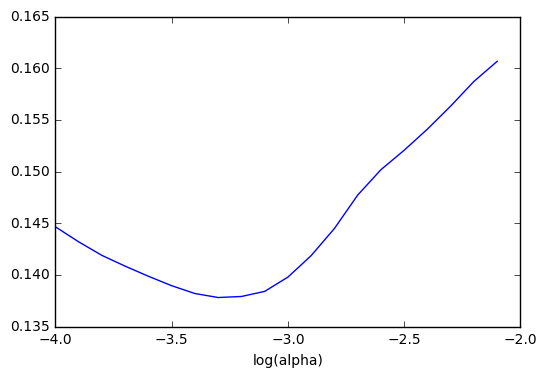

In [13]:
xx = []
yy = []
for k in np.arange(-4,-2, 0.1):
    est = Lasso(alpha = np.power(10., k), max_iter = 10000)
    sc = cross_val_score(est, X, y, cv=10, scoring = 'neg_mean_squared_error')
    xx.append(k)
    yy.append(np.sqrt(-np.mean(sc)))
plt.plot(xx,yy)
plt.xlabel('log(alpha)')
plt.show()

From this we obtain the optimal alpha = 10^(-3.2). Alternatively, we can use GridSearchCV:

In [14]:
est = Lasso(max_iter = 3000)
parameters = {'alpha':[np.power(10., k) for k in np.arange(-4,-2, 0.1)]}
clf = GridSearchCV(est, parameters,scoring = 'neg_mean_squared_error')
clf.fit(X,y)
print(clf.best_params_)


{'alpha': 0.00039810717055349773}


# Improvement of Lasso

Plain Lasso with the parameters choseen as above yields a Kaggle Score of roughly 0.126, which is much higher than the GradientBoost, which only scores 0.135. For the following analysis we therefore pick Lasso, and try to improve it. 

First, we check how well our model predicts the given data:

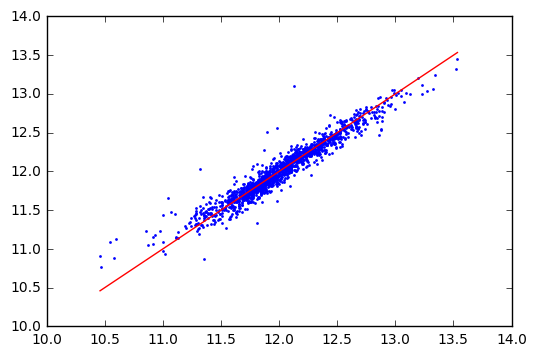

In [15]:
est = Lasso(alpha = 0.000398, max_iter = 10000)
est.fit(X, y)
y_2 = est.predict(X)
plt.scatter(y, y_2, s = 4, lw = 0)
plt.plot([np.min(y), np.max(y)], [np.min(y), np.max(y)], color = 'red')
plt.show()

It seems that the prediction (for the training set) is slightly too low for high-priced houses, and a bit too high for low-priced houses. We might want to correct that later. Also there are a few outliers which we could exclude from the estimator fitting. However, we have to be careful here, since this situation is prone to overfitting. 

A first attempt to improve the predictions for the tails is to use polynomial interpolation.

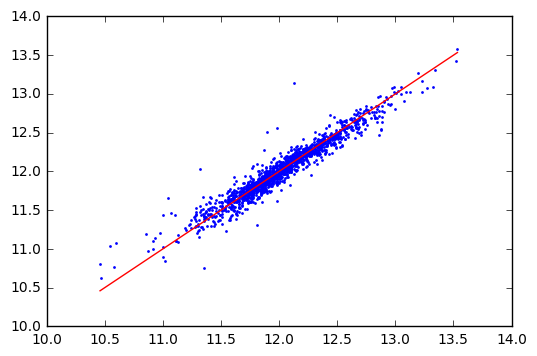

In [16]:
pipe = make_pipeline(PolynomialFeatures(5), Ridge())
Y = y_2[:, np.newaxis]
pipe.fit(Y, y)
y_3 = pipe.predict(y_2[:, np.newaxis])
plt.scatter(y, y_3, s = 4, lw = 0)
plt.plot([np.min(y), np.max(y)], [np.min(y), np.max(y)], color = 'red')
plt.show()

The improvement at the tails is not very satisfactory, and almost not noticable. The Kaggle Score did only improve by 0.001, which is not much. A problem for the Polynomial Interpolation could be that the mid-price range, where the predictions are closest to the real prices, are very dominant. The tails are only weakly represented, and do not have as much influence on the Polynomial Interpolation as we might have hoped. So we drop this approach for the moment.

Next, we remove those data points that produce the worst outliers in the predicitons. We do this recursively, and hope to improve the quality of the estimator (this modification of the training set is now clearly overfitting, but we hope that the out-of-sample-error can be reduced by this as well). We remove the 20 'worst' houses.

In [17]:
y = list(y)
est = Lasso(alpha = 0.000398, max_iter = 5000)
for i in range(20):
    est.fit(X,y)
    y_test = est.predict(X)
    li = [np.absolute(y[o]-y_test[o]) for o in range(len(y))]
    ii = li.index(max(li))
    del X[ii]
    del y[ii]

Based on this reduced training set we train the Lasso regression:

In [25]:
est = Lasso(alpha = 0.000398, max_iter = 5000)
est.fit(X,y)
y_pred = est.predict(X_test)

I don't bother doing cross-validation any more, since we are overfitting the training data. Polynomial interpolation didn't work too good before. I still want to do something similar to take care of the tails. To this end I manually define a third order polynomial mapping.

In [26]:
def poly_correction(y):
	A = [[np.power(12.2,3), np.power(12.2,2), 12.2, 1],[3*np.power(12.2,2), 2*12.2, 1, 0],[np.power(10.5,3), np.power(10.5,2), 10.5, 1],[np.power(13.5,3), np.power(13.5,2), 13.5, 1]]
	b = [12.2, 1, 10.3, 13.7]
	c = np.linalg.solve(A,b)
	return c[0]*np.power(y,3) + c[1]*np.power(y,2) + c[2]*y+c[3]

I obtained it by just 'visually' fitting the polynomial. Now we apply this to y_pred:

In [27]:
y_final = []
for j in y_pred:
    y_final.append(poly_correction(j))

We can also visually check the quality of the estimator on the training set:

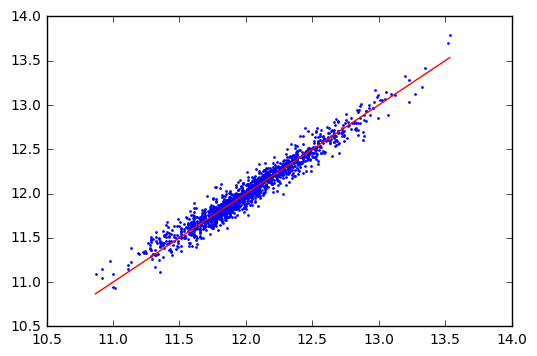

In [28]:
y_2 = est.predict(X)
y_3 = []
for j in y_2:
    y_3.append(poly_correction(j))
plt.scatter(y, y_3, s = 4, lw = 0)
plt.plot([np.min(y), np.max(y)], [np.min(y), np.max(y)], color = 'red')
plt.show()

Submission yields a Kaggle Score of 0.11954.